# Genomic neighborhood of the _Venturia inaequalis AvrRvi5_ effector candidates.

Jason Shiller has identified 10 _AvrRvi5_ candidates from comparative genomics and transcriptomics.
This document is part of an analysis of the genomic regions containing these candidates.

### Required software

The following packages were used in this analysis:

In [1]:
with open("requirements.txt", "r") as handle:
    print(handle.read())

bcbio-gff==0.6.2
biopython==1.65
decorator==4.0.2
ipykernel==4.0.3
ipython==4.0.0
ipython-genutils==0.1.0
ipywidgets==4.0.2
Jinja2==2.8
jsonschema==2.5.1
jupyter==1.0.0
jupyter-client==4.0.0
jupyter-console==4.0.2
jupyter-core==4.0.4
MarkupSafe==0.23
matplotlib==1.4.3
mistune==0.7.1
nbconvert==4.0.0
nbformat==4.0.0
nose==1.3.7
notebook==4.0.4
numpy==1.9.2
pandas==0.16.2
path.py==8.1.1
pexpect==3.3
pickleshare==0.5
ptyprocess==0.5
Pygments==2.0.2
pyparsing==2.0.3
python-dateutil==2.4.2
pytz==2015.4
pyzmq==14.7.0
qtconsole==4.0.1
scipy==0.16.0
simplegeneric==0.8.1
six==1.9.0
terminado==0.5
tornado==4.2.1
traitlets==4.0.0



To run this notebook for yourself create a new [virtual environment](https://virtualenv.pypa.io/en/latest/) in the prompt:

```
$ virtualenv env
$ source env/bin/activate
$ pip install numpy
$ pip install -r requirements
```

Then to run the notebook itself:

```
$ ipython notebook candidate_neighborhood.ipynb
```

Descriptor files for the output are written using the `%%writefile` cell magic after the file is created and before any descriptive analysis.

In [2]:
%matplotlib inline

In [3]:
import os
from os.path import join as pjoin
import subprocess
import re
import json
from collections import defaultdict
from tempfile import NamedTemporaryFile

from Bio import SeqIO
from Bio.Blast.Applications import NcbirpstblastnCommandline
from Bio.Blast.Applications import NcbiblastnCommandline
from Bio.Blast.Applications import NcbipsiblastCommandline
from Bio.Blast.Applications import NcbiblastpCommandline
from Bio.SeqFeature import SeqFeature
from Bio.SeqFeature import FeatureLocation
from BCBio import GFF
from IPython.display import SVG

import numpy as np
import pandas as pd
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib import patches
from matplotlib import gridspec
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.ticker import MultipleLocator

In [4]:
%run lib/gene_shapes.py
%run lib/collections.py
%run lib/subfeatures.py  # For GFF parsing
#%run lib/draw_wrappers.py
%run lib/links.py
%run lib/subset_features.py
%run lib/intergenic_features.py
%run lib/call_promer.py
%run lib/read_promer_coords.py
%run lib/utils.py
%run lib/axis.py

In [5]:
def tex_escape(text):
    """
        :param text: a plain text message
        :return: the message escaped to appear correctly in LaTeX
    """
    conv = {
        '&': r'\&',
        '%': r'\%',
        '$': r'\$',
        '#': r'\#',
        '_': r'\_',
        '{': r'\{',
        '}': r'\}',
        '~': r'\textasciitilde{}',
        '^': r'\^{}',
        '\\': r'\textbackslash{}',
        '<': r'\textless',
        '>': r'\textgreater',
    }
    regex = re.compile(
        '|'.join(conv.values())
        )
    return regex.sub(lambda match: conv[match.group()], text)

In [6]:
mpl.rcParams['text.usetex']=True
mpl.rcParams['text.latex.preamble'] = [
       r'\usepackage{siunitx}',   # i need upright \micro symbols, but you need...
       r'\sisetup{detect-all}',   # ...this to force siunitx to actually use your fonts
       r'\usepackage{helvet}',    # set the normal font here
       r'\usepackage{sansmath}',  # load up the sansmath so that math -> helvet
       r'\sansmath'               # <- tricky! -- gotta actually tell tex to use!
]

cdict = {
    'red':   ((0., 59/256, 59/256),
              (0.25, 120/256, 120/256),
              (0.5, 235/256, 235/236),
              (0.75, 225/256, 225/256),
              (1., 242/256, 242/256)),
    'green': ((0., 156/256, 156/256),
              (0.25, 183/256, 183/256),
              (0.5, 204/256, 204/256),
              (0.75, 175/256, 175/256),
              (1., 26/256, 26/256)),
    'blue':  ((0., 178/256, 178/256),
              (0.25, 197/256, 197/256),
              (0.5, 42/256, 42/256),
              (0.75, 0., 0.),
              (1., 0., 0.))
    }

zissou = LinearSegmentedColormap('Zissou', cdict)
plt.register_cmap(cmap=zissou)

cat_colours = [
    "#FF0000", "#00A08A", "#F2AD00",
    "#F98400", "#5BBCD6", "#046C9A",
    '#35274A', '#B40F20', "#D69C4E"
    ]

In [7]:
pd.set_option("display.max_colwidth", 800)
pd.set_option('display.max_rows', 1000)
THREADS = 3  # Number of CPUs available for calls to BLAST etc.

In [17]:
STEPS = {
    'data': 'data',
    'region': '01-genomic_region',
    'scaffold_extraction': '02-extracted_scaffolds',
    'scaffold_alignment': '03-aligned_scaffolds',
    'plotting_alignments': '04-plotted_scaffold_alignments',
    'broader_alignments': '05-plotted_broader_alignments',
    'ripcrawl_demo': '06-ripcrawl_demo',
    'gypsy': '07-gypsy'
    }

for step, dir_ in STEPS.items():
    if not os.path.isdir(dir_):
        os.mkdir(dir_)

## Candidates

Jason identified 10 candidate _AvrRvi5_ genes.
Nine were discovered by comparative genomics, and 1 was discovered by comparative transcriptomics of 14 day old _Venturia inaequalis_ cultures in potato dextrose broth \(PDB\).
`atg10719` was the candidate identified by the transcriptomics method, it is expressed in MNH120 but not in Race 5.

Below is a summary dataframe of the candidates:

In [9]:
ALL_CANDIDATES = pd.read_csv(pjoin(STEPS['data'], "summary.DNA-seq.RNA-seq.csv"))
ALL_CANDIDATES

,method,gene,aa_mutation,length,gb_acc,blast_desc,organism,evalue,identity
0,DNA-seq,atg161,T184I,237,No hit,NaN,NaN,NaN,NaN
1,DNA-seq,atg162,T417A,459,WP_030543571.1,Hypothetical protein,Streptomyces albus,0.000000008,29
2,DNA-seq,atg4020,"P174PNAKPDAKPDAKPDAKP, V155L",185,XP_007283047.1,Snoal-like polyketide cyclase family protein,Colletotrichum gloeosporioides,3E-029,40.15
3,DNA-seq,atg12487,V388M,403,ADT70774.1,Cellobiose dehydrogenase,Dichomera saubinetii,7E-013,55.56
4,DNA-seq,atg140* (not original gene call) first 15 amino acids removed,D83N,232,No hit,NaN,NaN,NaN,NaN
5,DNA-seq,atg7465,V463I,626,EKG19035.1,Glycoside hydrolase family 1,Macrophomina phaesolina,0,75.36
6,DNA-seq,atg10724,"K178N,K239R",292,No hit,NaN,NaN,NaN,NaN
7,DNA-seq,atg10703,G102A,202,No hit,NaN,NaN,NaN,NaN
8,DNA-seq,atg4290,L423S,436,XP_007795436.1,putative chloroperoxidase-like protein [Eutypa lata UCREL1],Eutypa lata,1E-022,38
9,RNA-seq,atg10719,Not expressed in race 5,86,No hit,No hit,No hit,No hit,No hit


In [10]:
ALL_CANDIDATES.ix[4, 'gene'] = 'atg140'
CANDIDATES = list(ALL_CANDIDATES['gene'])
GENOMES_TO_SEARCH = ['MNH120', 'USR5', 'B04']

In [57]:
GENOME_FILES = {
    'MNH120': {
        'fasta': pjoin(STEPS['data'], 'MNH120.genome.masked.fasta'),
        'gff': [
            pjoin(STEPS['data'], 'augustus.hints.GeneWithUTR.withNCBI_Fungi.gff3'),
            pjoin(STEPS['data'], 'MNH120.REPET_TEs.gff3'),
            pjoin(STEPS['data'], 'MNH120.REPET_SSRs.gff3'),
            pjoin(STEPS['data'], ('MNH120.genome.masked.fasta.TPSI.'
                                  'allHits.chains.bestPerLocus.gff3')),
            pjoin(STEPS['data'], 'MNH120.trf_repeats.gff3'),
            ],
        'aa': pjoin(STEPS['data'], 'MNH120.Auto.protein.faa'),
        'CRI': pjoin(STEPS['data'], 'MNH120.ripcrawl.CRI.track.bed'),
        },
    'B04': {
        'fasta': pjoin(STEPS['data'], 'B04.genome.fa'),
        'gff': [
            pjoin(STEPS['data'], 'B04.genes.gff3'),
            pjoin(STEPS['data'], ('B04.genome.fa.TPSI.allHits.'
                                  'chains.bestPerLocus.gff3')),
            pjoin(STEPS['data'], 'B04.trf_repeats.gff3'),
            ],
        'aa': pjoin(STEPS['data'], 'B04.protein.faa'),
        'CRI': pjoin(STEPS['data'], 'B04.ripcrawl.CRI.track.bed'),
        },
    'USR5': {
        'fasta': pjoin(STEPS['data'], 'I5V.gapfilled.final.fa'),
        'gff': [
            pjoin(STEPS['data'], 'I5V.PredictedPass.cleaned.gff3'),
            pjoin(STEPS['data'], ('I5V.gapfilled.final.fa.TPSI.'
                                  'allHits.chains.bestPerLocus.gff3')),
            pjoin(STEPS['data'], 'I5V.trf_repeats.gff3'),
            ],
        'aa': pjoin(STEPS['data'], 'I5V.PredictedPass.cleaned.genes.faa'),
        'CRI': pjoin(STEPS['data'], 'I5V.ripcrawl.CRI.track.bed'),
        },
    'I9A': {
        'fasta': pjoin(STEPS['data'], 'I9A.gapfilled.final.fa'),
        'gff': [
            pjoin(STEPS['data'], 'I9A.PredictedPass.cleaned.gff3'),
            ]
        },
    'I17V': {
        'fasta': pjoin(STEPS['data'], 'I17V.gapfilled.final.fa'),
        'gff': [
            pjoin(STEPS['data'], 'I17V.PredictedPass.cleaned.gff3'),
            ]
        },
    'I19A': {
        'fasta': pjoin(STEPS['data'], 'I19A.gapfilled.final.fa'),
        'gff': [
            pjoin(STEPS['data'], 'I19A.PredictedPass.cleaned.gff3'),
            ]
        },
    'I31A': {
        'fasta': pjoin(STEPS['data'], 'I31A.gapfilled.final.fa'),
        'gff': [
            pjoin(STEPS['data'], 'I31A.PredictedPass.cleaned.gff3'),
            ],
        },
    'I37A': {
        'fasta': pjoin(STEPS['data'], 'I37A.gapfilled.final.fa'),
        'gff': [
            pjoin(STEPS['data'], 'I37A.PredictedPass.cleaned.gff3'),
            ],
        },
    'I61A': {
        'fasta': pjoin(STEPS['data'], 'I61A.gapfilled.final.fa'),
        'gff': [
            pjoin(STEPS['data'], 'I61A.PredictedPass.cleaned.gff3'),
            ],
        },
    'I65V': {
        'fasta': pjoin(STEPS['data'], 'I65V.gapfilled.final.fa'),
        'gff': [
            pjoin(STEPS['data'], 'I65V.PredictedPass.cleaned.gff3'),
            ],
        }
    }

In [58]:
GENOMES = dict()
for isolate, files in GENOME_FILES.items():
    # Import genome fasta as dict keyed by scaffold.
    GENOMES[isolate] = SeqIO.to_dict(
        SeqIO.parse(files['fasta'], format="fasta")
        )
    for gff in files['gff']:
        # Parse GFF annotations.
        genome_with_features = GFF.parse(
            gff,
            base_dict=GENOMES[isolate]
            )
        """ bcbio-gff codes exons, mRNA etc as subfeatures which is now
        depreciated in biopython, this code fixes that issue. """
        new_genome_with_features = list()
        for scaffold in genome_with_features:
            new_features = list()
            for feature in scaffold.features:
                gene_features = subfeatures(feature)
                new_features.extend(gene_features)
            scaffold.features = new_features
            new_genome_with_features.append(scaffold)
        """ Genome with features doesn't have scaffolds without any gff 
        features. Here I update the existing records in genome with the 
        new ones containing features. """
        GENOMES[isolate].update(SeqIO.to_dict(new_genome_with_features))

SCAF_TO_GENOME = dict()
for isolate, genome in GENOMES.items():
    for scaffold in genome:
        if scaffold in SCAF_TO_GENOME:
            raise KeyError(
                "Scaffold:" + scaffold + 
                "is present in more than 1 genome"
                )
        SCAF_TO_GENOME[scaffold] = isolate

In [13]:
FEATURE_TO_SCAF = dict()
for isolate, genome in GENOMES.items():
    for scaffold, seq in genome.items():
        for feature in seq.features:
            if feature in FEATURE_TO_SCAF:
                raise KeyError(
                    "Feature:" + feature + 
                    "is present in more than 1 scaffold"
                    )
            FEATURE_TO_SCAF[feature.id] = scaffold

In [14]:
BLASTDBS = dict()
for isolate, files in GENOME_FILES.items():
    command = [
        "makeblastdb",
        "-in", files['fasta'],
        "-input_type", "fasta",
        "-dbtype", "nucl",
        "-title", isolate,
        "-parse_seqids",
        "-taxid", "5025",
        "-out", pjoin(STEPS['data'], isolate)
        ]
    subps = subprocess.Popen(
        command,
        stdout=subprocess.PIPE,
        stderr=subprocess.PIPE
        )
    stdout, stderr = subps.communicate()
    BLASTDBS[isolate] = pjoin(STEPS['data'], isolate)

command = [
    "blastdb_aliastool",
    "-dblist", " ".join([v for k, v in BLASTDBS.items()]),
    "-dbtype", "nucl",
    "-title", 'combined',
    "-out", pjoin(STEPS['data'], 'combined')
    ]

subps = subprocess.Popen(
    command,
    stdout=subprocess.PIPE,
    stderr=subprocess.PIPE 
    )
stdout, stderr = subps.communicate()
BLASTDBS['combined'] = pjoin(STEPS['data'], 'combined')

## Genomic region containing
### Step - `region`

Now lets find the position of our candidates in MNH120.

In [15]:
atgs = list()
for scaffold_name, scaffold in GENOMES['MNH120'].items():
    for feature in scaffold.features:
        if feature.id in CANDIDATES:
            atg = {
                "scaffold": scaffold_name,
                "id": feature.id,
                "type": feature.type,
                "start": feature.location.start,
                "end": feature.location.end,
                "strand": feature.strand,
                "feature": feature
                }
            atgs.append(atg)

for atg in atgs:
    print(
        "The {type} {id} is found in scaffold ".format(**atg) +
        "{scaffold} from position {start} to {end}.".format(**atg)
        )
    print(atg['feature'])

The gene atg7465 is found in scaffold scaffold_893 from position 99033 to 100911.
type: gene
location: [99033:100911](-)
id: atg7465
qualifiers:
    Key: ID, Value: ['atg7465']
    Key: Name, Value: ['atg7465']
    Key: Note, Value: ['gi|312221728|emb|CBY01668.1|', 'Percentage identity 60.87', 'hypothetical protein LEMA_P004550.1 [Leptosphaeria maculans JN3]']
    Key: source, Value: ['AUGUSTUS_Train120estTranscript']

The gene atg140 is found in scaffold scaffold_38 from position 24287 to 25314.
type: gene
location: [24287:25314](-)
id: atg140
qualifiers:
    Key: ID, Value: ['atg140']
    Key: Name, Value: ['atg140']
    Key: source, Value: ['AUGUSTUS_Train120estTranscript']

The gene atg4290 is found in scaffold scaffold_447 from position 349816 to 351226.
type: gene
location: [349816:351226](+)
id: atg4290
qualifiers:
    Key: ID, Value: ['atg4290']
    Key: Name, Value: ['atg4290']
    Key: source, Value: ['AUGUSTUS_Train120estTranscript']

The gene atg4020 is found in scaffold sc

In [16]:
descriptor = \
"""A plot of the genomic region surrounding {these_candidates} on scaffold 996 of _Venturia inaequalis_ MNH120. 
In the repet track SSRs are shown in orange and TEs are shown in greeny-blue.

The plot was generated with python3.4 with matplotlib.

This file depends on the files:

- augustus.hints.GeneWithUTR.withNCBI_Fungi.gff3
- MNH120.genome.masked.fasta
- REPET_SSRs.gff3
- REPET_TEs.gff3


Both are available on scinet or on [JGI](http://genome.jgi.doe.gov/Venin1/Venin1.home.html).

This file is free to use and distribute."""

scaffolds = defaultdict(list)
for atg in atgs:
    scaffolds[atg['scaffold']].append(atg['id'])

fmt = {
    
    'y': 2.05,
    'rotation': 'vertical',
    'verticalalignment': 'bottom',
    'horizontalalignment': 'center',
    }
names_to_print = {c: {'s': c,
                      'y': 2.05,
                      'rotation': 'vertical',
                      'verticalalignment': 'bottom',
                      'horizontalalignment': 'center',
                      } for c in CANDIDATES}

other_shapes = {
    'mnh120_REPET_TEs': Triangle(width=0.9, y_offset=0.05, facecolor=cat_colours[1], linewidth=0),
    'mnh120_REPET_SSRs': Triangle(width=0.9, y_offset=0.05, facecolor=cat_colours[3], linewidth=0),
    }

title_font = {'fontsize': 10, 'verticalalignment': 'baseline'}

for scaffold, candidates in scaffolds.items():
    fig, ax = plt.subplots()
    feature_patches, text_patches = draw_region(
        seq=GENOMES['MNH120'][scaffold],
        exon=Triangle(width=0.9, y_offset=1.05, facecolor='black', linewidth=0),
        intron=OpenTriangle(width=0.45, y_offset=1.5, fill=False,),
        intron_threshold=1000,
        other_shapes=other_shapes,
        names_to_print=names_to_print,
        )
    for patch in feature_patches:
        ax.add_patch(patch)
    for patch in text_patches:
        ax.text(**patch)

    ax.set_ylim([0, 2.])
    ax.set_yticks([0.5, 1.5])
    ax.set_yticklabels(['REPET', 'Genes'])
    ax.set_xlim([0, len(GENOMES['MNH120'][scaffold])])
    if 'atg4290' in candidates:
        ax.set_xlim([300000, len(GENOMES['MNH120'][scaffold])])
    elif 'atg12487' in candidates:
        ax.set_xlim([200000, 300000])
        
    ax.set_title(tex_escape(scaffold), loc='left', fontdict=title_font)
    fig.set_size_inches(10, 3)
    fig.savefig(pjoin(STEPS['region'], scaffold + '_region.svg'))
    plt.show()

TypeError: __init__() missing 2 required positional arguments: 'x' and 'y'

Genes are shown in blue, SSRs are shown in green, TEs are shown in red.

There are predicted transposable element just upstream of `atg10719` and `atg10703`.
This is interesting because `atg10719` is not expressed in race 5.
I need to look at the genome of race 5 to see if this potential insertion is present (or more interestingly absent) in the promoter region of `atg10719`.

As far as gene function this plot isn't terribly informative just yet.

In [ ]:
descriptor = """\
Nucleotide fasta sequences of genes on a scaffold in _Venturia inaequalis_ MNH120.
Sequences were extracted using Biopython 1.6.5 in Python 3.4.

Sequences were extracted from MNH120.genome.masked.fasta using the annotations in augustus.hints.GeneWithUTR.withNCBI_Fungi.gff3.

Both files are available on scinet or [JGI](http://genome.jgi.doe.gov/Venin1/Venin1.home.html).
"""

scaffolds = set([atg['scaffold'] for atg in atgs])

sequences = list()
for scaffold in scaffolds:
    for feature in GENOMES['MNH120'][scaffold].features:
        if feature.type != "gene":
            continue  # we don't want the TE
        seq = feature.extract(GENOMES['MNH120'][scaffold])
        seq.id = feature.id
        seq.name = ""
        seq.description = ""
        sequences.append(seq)

SeqIO.write(sequences, pjoin(STEPS['region'], "mnh120_nearby_genes.fasta"), format="fasta")

In [ ]:
def synteny_finder(sequences, max_depth=2, threads=3, identity_threshold=0.75):
    depth = 0
    output_columns = [
        "qseqid",
        "sseqid",
        "qlen",
        "slen",
        "qstart",
        "qend",
        "sstart",
        "send",
        "evalue",
        "bitscore",
        "score",
        "length",
        "pident",
        "nident",
        ]
    with NamedTemporaryFile(mode='w') as inhandle, NamedTemporaryFile(mode='w') as outhandle:
        SeqIO.write(sequences, inhandle.name, format="fasta")
        blastn_cline = NcbiblastnCommandline(
            query=inhandle.name,
            db=BLASTDBS['combined'],
            out=outhandle.name,
            outfmt='"6 ' + " ".join(output_columns) + '"',
            evalue=0.1,
            num_threads=threads
            )
        stdout, stderr = blastn_cline()
        #print(blastn_cline)
        #print(stdout)
        #print(stderr)
        blastn_results = pd.read_table(
            outhandle.name,
            names=output_columns,
            )
        
    isolates = list()
    qisolates = list()
    scaffolds = list()
    for i, row in blastn_results.iterrows():
        isolates.append(SCAF_TO_GENOME[row['sseqid']])
        scaffolds.append(FEATURE_TO_SCAF[row['qseqid']])
        qisolates.append(SCAF_TO_GENOME[
            FEATURE_TO_SCAF[row['qseqid']]
            ])
    blastn_results.insert(1, 'isolate', pd.Series(isolates))
    blastn_results.insert(2, 'scaffold', pd.Series(scaffolds))
    blastn_results.insert(1, 'qisolate', pd.Series(qisolates))
    blastn_results.to_csv('test2.csv')
    def hlogfmt(series):
        hlog = {
            'homologue_id': series['qseqid'],
            'isolate': series['isolate'],
            'scaffold': series['sseqid'],
            'start': min(series['sstart'], series['send']),
            'end': max(series['sstart'], series['send']),
            'strand': int((series['send'] - series['sstart']) / 
                    abs(series['send'] - series['sstart'])),
            'nident': series['nident'],
            }
        return hlog

    # scaffold: isolate: syntenic scaffolds 
    candidate_scaffolds = defaultdict(lambda: defaultdict(list))
    candidate_homologues = defaultdict(lambda: defaultdict(list))
    
    for isolate, table in blastn_results.groupby(['qisolate']):
        for scaffold, subtable in table.groupby(['scaffold']):
            if scaffold not in candidate_scaffolds[scaffold][isolate]:
                candidate_scaffolds[scaffold][isolate].append(scaffold)

    for scaffold, table in blastn_results.groupby(['scaffold']):
        for isolate, subtab in table.groupby(['isolate']):
            scaffolds = list()
            provisional_scafs = defaultdict(int)

            """ First we loop through and find probable homologues
            and add their scaffolds to the provisional scaffold list.
            """
            for qseqid, subsubtab in subtab.groupby(['qseqid']):
                partials = defaultdict(list)
                qlen = 0
                for i, row in subsubtab.iterrows():
                    qlen = row['qlen'] 
                    ident = row['nident'] / row['qlen']

                    """ If match is long and sim enough, add it straight to the list. """
                    """ Otherwise, add short matches to a list of partial matches.
                        Some hits have large gaps within them but they could still 
                        be an homologue. """

                    if ident >= identity_threshold:
                        provisional_scafs[row['sseqid']] += 1
                        candidate_homologues[qseqid][isolate].append(
                            hlogfmt(row)
                            )
                    elif row['pident'] >= identity_threshold * 100.:
                        partials[row['sseqid']].append(row)

                """ Resolve partial matches. If the combined partial matches on a
                single scaffold covers >= 75% of the the qseq I add it to the 
                homologue list."""
                for scaf, rows in partials.items():
                    qseq = set(range(1, qlen + 1))
                    for row in rows:
                        start = min(row['qstart'], row['qend'])
                        end = max(row['qstart'], row['qend'])
                        qseq.difference_update(set(range(start, end + 1)))
                    if len(qseq) <= qlen - (identity_threshold * qlen):
                        provisional_scafs[scaf] += 1
                        candidate_homologues[qseqid][isolate].extend(
                            [hlogfmt(row) for row in rows]
                            )
            """ Go through the putative homologues and find the probable syntenic scaffolds. """
            qseqids = list()  # Non-redundant list of qseqids in order of search
            for qseqid in subtab['qseqid']:
                if qseqid not in qseqids:
                    qseqids.append(qseqid)
            """ Find the scaffold with the homologue with the greatest number 
            of other homologues. """
            for qseqid in qseqids:
                homologues = candidate_homologues[qseqid][isolate]
                max_synteny = 0
                max_scaf = None 
                for hlog in homologues:
                    syn_idx = provisional_scafs[hlog['scaffold']]
                    if syn_idx > max_synteny:
                        max_synteny = syn_idx
                        max_scaf = hlog['scaffold']
                if max_scaf is not None:
                    scaffolds.append(max_scaf)
            """ Add the scaffolds to the candidate scaffolds, in order of search, 
            without duplicates. """
            for scaf in scaffolds:
                if scaf not in candidate_scaffolds[scaffold][isolate]:
                    candidate_scaffolds[scaffold][isolate].append(scaf)

    scaffolds = defaultdict(set)
    for scaf, isolates in candidate_scaffolds.items():
        for isolate, d in isolates.items():
            scaffolds[isolate].update(set(d))

    new_sequences = list()
    for isolate, scafs in scaffolds.items():
        for scaffold in scafs:
            for feature in GENOMES[isolate][scaffold].features:
                if feature.type != "gene":
                    continue  # we don't want the TE
                seq = feature.extract(GENOMES[isolate][scaffold])
                seq.id = feature.id
                seq.name = ""
                seq.description = ""
                new_sequences.append(seq)

    if depth < max_depth and len(sequences) < len(new_sequences):
        candidate_scaffolds, candidate_homologues = synteny_finder(new_sequences, max_depth=max_depth-1)
    elif len(sequences) == len(new_sequences):
        print('search has converged')
    elif len(sequences) > len(new_sequences):
        print('something is wrong')

    return candidate_scaffolds, candidate_homologues

In [ ]:
sequences = SeqIO.parse(pjoin(STEPS['region'], "mnh120_nearby_genes.fasta"), format="fasta")
candidate_scaffolds, candidate_homologues = synteny_finder(list(sequences), max_depth=1)

with open(pjoin(STEPS['region'], 'candidate_scaffolds.json'), 'w') as handle:
    json.dump(candidate_scaffolds, handle, indent=2)
with open(pjoin(STEPS['region'], 'candidate_homologues.json'), 'w') as handle:
    json.dump(candidate_homologues, handle, indent=2)

In [ ]:
with open(pjoin(STEPS['region'], 'candidate_scaffolds.json'), 'r') as handle:
    candidate_scaffolds = json.load(handle)

scaffolds = defaultdict(set)
for key_scaffold, isolates in candidate_scaffolds.items():
    for isolate, scafs in isolates.items():
        scaffolds[isolate].update(set(scafs))

sequences = list()
for isolate, scafs in scaffolds.items():
    for scaffold in scafs:
        for feature in GENOMES[isolate][scaffold].features:
            if feature.type != "gene" or isolate not in GENOMES_TO_SEARCH:
                continue  # we don't want the TE
            seq = feature.extract(GENOMES[isolate][scaffold])
            seq.id = feature.id
            seq.name = ""
            seq.description = ""
            sequences.append(seq)

SeqIO.write(sequences, pjoin(STEPS['region'], "nearby_genes.fasta"), format="fasta")

## Comparison of `atg10719` in MNH120 and race 5

Lets look at comparing the genomic regions surrounding `atg10719` in MNH120 and race 5.
First we'll determine the level of synteny and colinearity between the region.
Then i'd like to do a local alignment of the `atg10719` and the upstream region of this gene, especially looking at the transposon.

### Step - `scaffold_extraction`

In [ ]:
descriptor = """\
"""

with open(pjoin(STEPS['region'], 'candidate_scaffolds.json'), 'r') as handle:
    candidate_scaffolds = json.load(handle)

with open(pjoin(STEPS['region'], 'candidate_homologues.json'), 'r') as handle:
    candidate_homologues = json.load(handle)
    
t = defaultdict(set)
for scaf, homologous_scafs in candidate_scaffolds.items():
    t[SCAF_TO_GENOME[scaf]].add(scaf)
    for isolate, hscafs in homologous_scafs.items():
        t[isolate].update(set(hscafs))

for gene, homologues in candidate_homologues.items():
    if gene not in CANDIDATES:
        continue
    for isolate, hlogs in homologues.items():
        for hlog in hlogs:
            t[isolate].add(hlog['scaffold'])
    
for isolate in GENOMES_TO_SEARCH:
    scaffold_sequences =[GENOMES[isolate][s] for s in t[isolate]]
    for scaffold in scaffold_sequences:
        scaffold_filename = pjoin(
            STEPS['scaffold_extraction'],
            '{}-{}.fasta'.format(isolate, scaffold.id)
            )
        with open(scaffold_filename, 'w') as handle:
            SeqIO.write(scaffold, handle, "fasta")

### Step - `scaffold_alignment`

In [ ]:
%run lib/call_promer.py

In [ ]:
scaffold_files = os.listdir(STEPS['scaffold_extraction'])
scaffold_files = [f for f in scaffold_files if f.endswith('.fasta')]

promer_files = defaultdict(dict)
for i in range(len(scaffold_files)):
    for j in range(i, len(scaffold_files)):
        isolate_i = scaffold_files[i].split('-')[0]
        isolate_j = scaffold_files[j].split('-')[0]
        scaf_i = os.path.splitext(scaffold_files[i].split('-')[1])[0]
        scaf_j = os.path.splitext(scaffold_files[j].split('-')[1])[0]
        prefix = '{}-{}-promer'.format(scaf_i, scaf_j)
        if scaf_i == scaf_j:
            same = True
        same = False
        if same:
            maxmatch = True
        else:
            maxmatch = False
        promer_delta, promer_coords = call_promer(
            reference=pjoin(STEPS['scaffold_extraction'], scaffold_files[i]),
            query=pjoin(STEPS['scaffold_extraction'], scaffold_files[j]),
            minmatch=10,
            coords=True,
            maxmatch=maxmatch,
            prefix=pjoin(STEPS['scaffold_alignment'], prefix),
            quiet=True,
            )
        promer_files[scaf_i][scaf_j] = {
            'reference_isolate': isolate_i,
            'reference_scaffold': scaf_i,
            'query_isolate': isolate_j,
            'query_scaffold': scaf_j,
            'delta': promer_delta,
            'coords': promer_coords,
            }
        promer_files[scaf_j][scaf_i] = promer_files[scaf_i][scaf_j]

with open(pjoin(STEPS['scaffold_alignment'], 'promer_files.json'), 'w') as handle:
    json.dump(
        promer_files,
        handle,
        indent=4,
        separators=(',', ': '),
        )

### Step - `plotting_alignments`

In [18]:
with open(pjoin(STEPS['region'], 'candidate_homologues.json'), 'r') as handle:
    candidate_homologues = json.load(handle)

names_to_print = defaultdict(list)
for candidate in CANDIDATES:
    for isolate in GENOMES_TO_SEARCH:
        for hlog in candidate_homologues[candidate][isolate]:
            seq = GENOMES[isolate][hlog['scaffold']]
            features = subset_features(seq, hlog['start'], hlog['end'])
            features = [f for f in features if f.type == 'gene']
            features = [f for f in features if f.strand == hlog['strand']]
            if len(features) == 0:
                start = hlog['start']
                end = hlog['end']
                s = candidate + ' match'
            else:
                feature = features[0]
                start = feature.location.start
                end = feature.location.end
                id_ = feature.id
                s = id_.lstrip('exon.')
                if isolate == 'B04':
                    s = '.'.join(id_.split('.')[1:])

            names_to_print[hlog['scaffold']].append({
                's': tex_escape(s),
                'x': (start + end) / 2,
                'y': 1.1,
                'rotation': 'vertical',
                'verticalalignment': 'bottom',
                'horizontalalignment': 'center',
                })

In [19]:
with open(pjoin(STEPS['region'], 'candidate_homologues.json'), 'r') as handle:
    candidate_homologues = json.load(handle)

buscos = dict()
buscos['MNH120'] = pd.read_csv(pjoin(STEPS['data'], 'full_table_MNH_Fungi'), sep='\t')
buscos['B04'] = pd.read_csv(pjoin(STEPS['data'], 'full_table_B04_Fungi'), sep='\t')
buscos['USR5'] = pd.read_csv(pjoin(STEPS['data'], 'full_table_IV5.Fungi'), sep='\t')

secretome = dict()
location_cols = ['seqid', 'location', 'membrane']
table = pd.read_csv('data/MNH120.location.tsv', sep='\t', names=location_cols)
secretome['MNH120'] = set(table.seqid[(table.location == 'secreted') & (table.membrane == False)])
table = pd.read_csv('data/I5V.location.tsv', sep='\t', names=location_cols)
secretome['USR5'] = set(table.seqid[(table.location == 'secreted') & (table.membrane == False)])
table = pd.read_csv('data/B04.location.tsv', sep='\t', names=location_cols)
secretome['B04'] = set(table.seqid[(table.location == 'secreted') & (table.membrane == False)])

names_to_print = defaultdict(list)
for candidate in CANDIDATES:
    for isolate in GENOMES_TO_SEARCH:
        for hlog in candidate_homologues[candidate][isolate]:
            seq = GENOMES[isolate][hlog['scaffold']]
            features = subset_features(seq, hlog['start'], hlog['end'])
            features = [f for f in features if f.type == 'gene']
            features = [f for f in features if f.strand == hlog['strand']]
            if len(features) == 0:
                start = hlog['start']
                end = hlog['end']
                s = candidate + ' match'
            else:
                feature = features[0]
                start = feature.location.start
                end = feature.location.end
                id_ = feature.id
                s = id_.lstrip('exon.')
                if isolate == 'B04':
                    s = id_.split('.', 1)[1]

            names_to_print[hlog['scaffold']].append({
                's': tex_escape(s),
                'x': (start + end) / 2,
                'y': 1.15,
                'rotation': 'vertical',
                'verticalalignment': 'bottom',
                'horizontalalignment': 'center',
                })
            
for isolate, table in buscos.items():
    for i, row in table.iterrows():
        start = row['Start']
        end = row['End']
        s = '*'
        scaffold = row['Scaffold']
        names_to_print[scaffold].append({
            's': tex_escape(s),
            'x': (start + end) / 2,
            'y': 1.05,
            'rotation': 'vertical',
            'verticalalignment': 'bottom',
            'horizontalalignment': 'center',
            })

for isolate, seqids in secretome.items():
    for scaffold, seq in GENOMES[isolate].items():
        for feature in seq.features:
            if feature.id in seqids:
                start = feature.location.start
                end = feature.location.end
                s = '+'
                names_to_print[scaffold].append({
                    's': tex_escape(s),
                    'x': (start + end) / 2,
                    'y': 1.05,
                    'rotation': 'vertical',
                    'verticalalignment': 'bottom',
                    'horizontalalignment': 'center',
                    })

In [20]:
def draw_synteny(
        data,
        fig,
        tick_frequency=50000,
        thres=85,
        hspace=1,
        height_ratios=None,
        within_links=[],
        cpoint=20
        ):
    max_length = 0
    for grp in data:
        if grp['seqs'] is None:
            grp['seqs'] = [GENOMES[grp['name']][s] for s in grp['scaffolds']]
        if grp['scaf_names'] is None:
            grp['scaf_names'] = grp['scaffolds']
        if grp['xlims'] is None:
            grp['xlims'] = [(0, l) for l in[len(s) for s in grp['seqs']]]
        if grp['yratios'] is None:
            grp['yratios'] = [1 for y in grp['ylims']]
        length = sum([abs(l[1] - l[0]) for l in grp['xlims']])
        if length > max_length:
            max_length = length

    gs = gridspec.GridSpec(len(data), 1, hspace=hspace, height_ratios=height_ratios)

    # Create axes and draw genes
    exon = new_shape(Triangle, width=1, y_offset=-0.5, facecolor='black', linewidth=0)
    gene = new_shape(Feature, shape=exon)
    nblock = new_shape(Rectangle, width=1, y_offset=-0.5, facecolor='red', linewidth=0)
    nblock = new_shape(Feature, shape=nblock)

    for i, grp in enumerate(data):
        grp['axes'] = compound_axis(
            grp['xlims'],
            grp['ylims'],
            gs[i],
            fig,
            xscaling=max_length,
            hspace=0,
            )
        for ax, name in zip(grp['axes'][0], grp['scaf_names']):
            if ax is not None:
                ax.tick_params(labeltop='off', labelbottom='off')
                ax.xaxis.set_major_locator(MultipleLocator(base=tick_frequency))
                ax.xaxis.set_major_formatter(SeqFormatter())
                ax.text(1.0, 0, 
                    tex_escape(name),
                    transform=ax.transAxes,
                    verticalalignment='center',
                    rotation='vertical',
                    horizontalalignment='left',
                    )
                #ax.text(0, 1.05, tex_escape(name), transform=ax.transAxes, verticalalignment='bottom')

        for ax, seq in zip(grp['axes'][0], grp['seqs']):
            track = FeatureTrack()
            #nblocks = [f for f in seq.features if 'nn2gff' in f.qualifiers['source']]
            #track.add_bpfeatures(feats, obj=nblock)
            feats = [f for f in seq.features if f.type == 'gene']
            track.add_bpfeatures(feats, obj=gene)
            feature_patches = track.draw(ax)
            trans = blended_transform_factory(ax.transData, ax.transAxes)
            if seq.id in names_to_print:
                for name in names_to_print[seq.id]:
                    xlims = ax.get_xlim()
                    if min(xlims) <= name['x'] <= max(xlims):
                        ax.text(transform=trans, **name)

        grp['axes'][0, 0].set_yticks([])
        grp['axes'][0, 0].set_ylabel('Genes')

    # Draw other features/tracks here
    for i, grp in enumerate(data):
        if grp['name'] == 'MNH120':
            grp['axes'][1, 0].set_yticks([])
            grp['axes'][1, 0].set_ylabel('TEs')
            for ax, seq in zip(grp['axes'][1], grp['seqs']):
                track = FeatureTrack()
                feats = [f for f in seq.features if 'mnh120_REPET_TEs' in f.qualifiers['source']]
                track.add_bpfeatures(feats, obj=gene)
                feature_patches = track.draw(ax)

        grp['axes'][-2, 0].set_yticks([])
        grp['axes'][-2, 0].set_ylabel('TPSI')
        for ax, seq in zip(grp['axes'][-2], grp['seqs']):
            track = FeatureTrack()
            feats = [f for f in seq.features if 'TransposonPSI' in f.qualifiers['source']]
            track.add_bpfeatures(feats, obj=gene)
            feature_patches = track.draw(ax)
        cri = bedtrack_parser(GENOME_FILES[grp['name']]['CRI'], grp['scaffolds'])
        for ax, scaf in zip(grp['axes'][-1], grp['scaffolds']):
            x = cri[scaf]['x']
            y = cri[scaf]['y']
            x, y = zip(*sorted(zip(x, y), key=lambda t: t[0]))
            ax.plot(x, y, color='black', lw=0.5)
        grp['axes'][-1, 0].set_ylabel('CRI')
        grp['axes'][-1, 0].set_yticks([-3, 0, 3])

    # Draw links
    all_links = list()
    colours = cat_colours[2], cat_colours[0]
    for i in within_links:
        for scafleft, axleft in zip(data[i]['scaffolds'], data[i]['axes'][-1]):
            lims = [0, sum(data[0]['yratios'])/data[i]['yratios'][-1]]
            for scafright, axright in zip(data[i]['scaffolds'], data[i]['axes'][-1]):
                link = new_shape(
                    CrossLink,
                    ax1=axleft,
                    ax2=axright,
                    ax1_yrange=lims,
                    ax1_cpoint=cpoint,
                    ax2_cpoint=cpoint,
                    facecolor=colours[(i + 1) % 2],
                    linewidth=0.,
                    )
                links = LinkCollection(link, add_to_fig=True)
                x = links.add_coords(
                    fp=promer_files[scafleft][scafright]['coords'],
                    r=scafleft,
                    q=scafright,
                    thres=thres,
                    )
                all_links.append(links)
    
    for i in range(1, len(data)):
        dtop = data[i - 1]
        dbot = data[i]
        for scaftop, axtop in zip(dtop['scaffolds'], dtop['axes'][-1]):
            for scafbot, axbot in zip(dbot['scaffolds'], dbot['axes'][-1]):
                if axtop is None or axbot is None:
                    continue
                toplims = [sum(dtop['yratios'])/dtop['yratios'][-1], 0]
                botlims = [0, sum(dbot['yratios'])/dbot['yratios'][0]]
                link = new_shape(
                    CrossLink,
                    ax1=axtop,
                    ax2=axbot,
                    ax1_yrange=toplims,
                    ax2_yrange=botlims,
                    facecolor=colours[i % 2],
                    linewidth=0.,
                    )
                links = LinkCollection(link, add_to_fig=True)
                x = links.add_coords(
                    fp=promer_files[scaftop][scafbot]['coords'],
                    r=scaftop,
                    q=scafbot,
                    thres=thres,
                    )
                all_links.append(links)
    for link in all_links:
        link.draw()
    return data

### atg140

First lets look at the region surrounding atg140

In [21]:
with open(pjoin(STEPS['region'], 'candidate_homologues.json'), 'r') as handle:
    candidate_homologues = json.load(handle)

for isolate, hlogs in candidate_homologues['atg140'].items():
    print(isolate, 'has', len(hlogs), 'copies.')

I17V has 3 copies.
I37A has 3 copies.
I65V has 3 copies.
I61A has 4 copies.
I19A has 3 copies.
I31A has 3 copies.
B04 has 3 copies.
I9A has 4 copies.
USR5 has 4 copies.
MNH120 has 4 copies.


So we're probably looking at an expanded gene. 
First lets look at the closest homologues only.

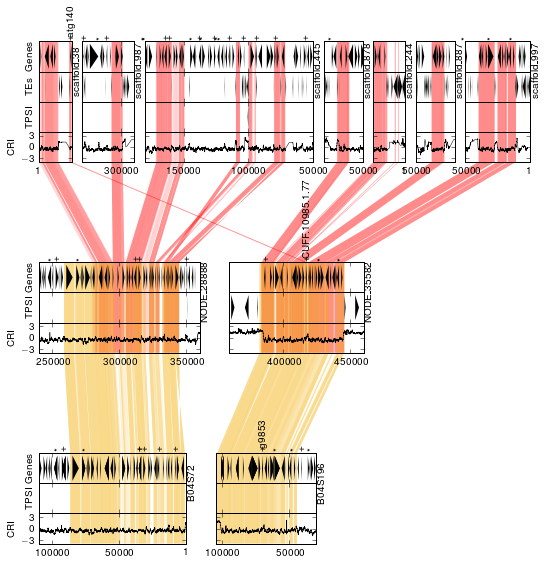

In [22]:
with open(pjoin(STEPS['scaffold_alignment'], 'promer_files.json'), 'r') as handle:
    promer_files = json.load(handle)

data = [
    {
        'name': 'MNH120',
        'scaffolds': [
            'scaffold_38',
            'scaffold_987',
            'scaffold_445', 
            'scaffold_878',
            'scaffold_244',
            'scaffold_887',
            'scaffold_997'
            ],
        'scaf_names': None,
        'seqs': None,
        'xlims': [(0, 25314), (330000, 290000), (180000, 50000), (80000, 50000), (24499, 0), (50000, 20000), (50000, 0)],
        'ylims': [(-0.6, 0.6), (-0.6, 0.6), (-0.6, 0.6), (-4, 4)],
        'yratios': None,
    },
    {
        'name': 'USR5',
        'scaffolds': ['NODE_28888_length_496775_cov_15.218104', 'NODE_35582_length_606476_cov_15.460932'],
        'scaf_names': ['NODE_28888', 'NODE_35582'],
        'seqs': None,
        'xlims': [(240000, 360000), (360000, 460000)],
        'ylims': [(-0.6, 0.6), (-0.6, 0.6), (-4, 4)],
        'yratios': None,
    },
    {
        'name': 'B04',
        'scaffolds': ['B04S72', 'B04S196'],
        'scaf_names': None,
        'seqs': None,
        'xlims': [(110000, 0), (104567, 30000),],
        'ylims': [(-0.6, 0.6), (-0.6, 0.6), (-4, 4)],
        'yratios': None,
    },
    ]

fig = plt.figure(figsize=(9, 9))
data = draw_synteny(
    data,
    fig,
    tick_frequency=50000,
    thres=85,
    height_ratios=[4, 3, 3]
    )
fig.savefig(pjoin(STEPS['plotting_alignments'], 'atg140_synteny.png'), dpi=600)
fig.savefig(pjoin(STEPS['plotting_alignments'], 'atg140_synteny.svg'))

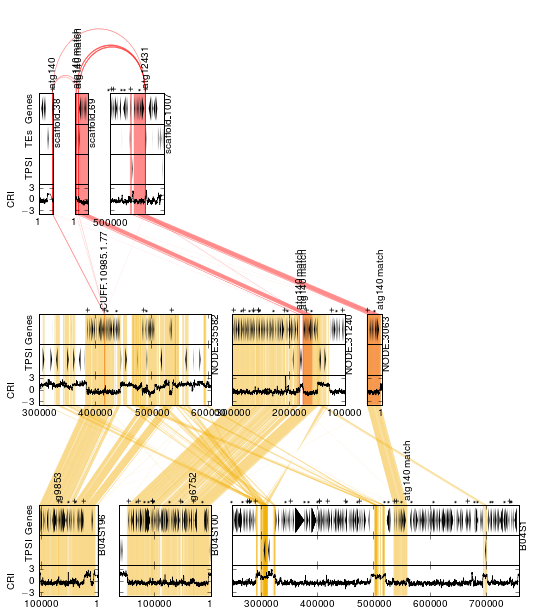

In [24]:
with open(pjoin(STEPS['scaffold_alignment'], 'promer_files.json'), 'r') as handle:
    promer_files = json.load(handle)

data = [
    {
        'name': 'MNH120',
        'scaffolds': ['scaffold_38', 'scaffold_69', 'scaffold_1007'],
        'scaf_names': None,
        'seqs': None,
        'xlims': [(0, 25314), (0, 23482), (500000, 595422)],
        'ylims': [(-0.6, 0.6), (-0.6, 0.6), (-0.6, 0.6), (-4, 4)],
        'yratios': None,
    },
    {
        'name': 'USR5',
        'scaffolds': [
            'NODE_35582_length_606476_cov_15.460932',
            'NODE_31240_length_299966_cov_15.629742',
            'NODE_3063_length_27277_cov_15.580489',
            ], 
        'scaf_names': ['NODE_35582', 'NODE_31240', 'NODE_3063'],
        'seqs': None,
        'xlims': [(300000, 605022), (299486, 100000), (27322, 0)],
        'ylims': [(-0.6, 0.6), (-0.6, 0.6), (-4, 4)],
        'yratios': None,
    },
    {
        'name': 'B04',
        'scaffolds': ['B04S196', 'B04S100', 'B04S1'],
        'scaf_names': None,
        'seqs': None,
        'xlims': [(104567, 0), (161523, 0), (250000, 758575)],
        'ylims': [(-0.6, 0.6), (-0.6, 0.6), (-4, 4)],
        'yratios': None,
    },
    ]

tick_frequency = 100000
fig = plt.figure(figsize=(9, 9))
data = draw_synteny(
    data,
    fig,
    tick_frequency=100000,
    thres=70,
    height_ratios=[4, 3, 3],
    within_links=[0]
    )
fig.savefig(pjoin(STEPS['plotting_alignments'], 'atg140_all_homologues.png'), dpi=600)
fig.savefig(pjoin(STEPS['plotting_alignments'], 'atg140_all_homologues.svg'))

### atg161 & 162

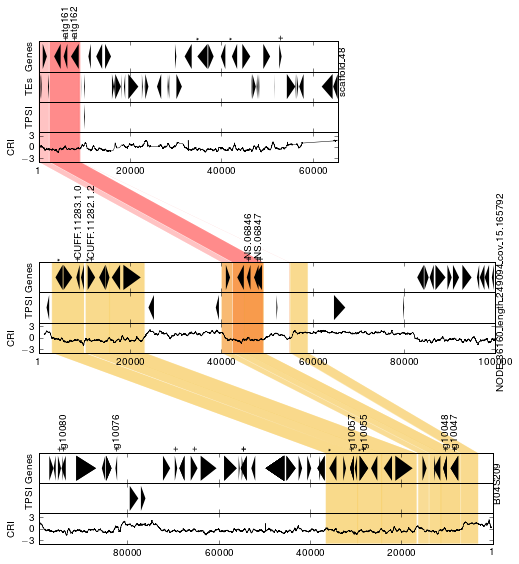

In [25]:
with open(pjoin(STEPS['scaffold_alignment'], 'promer_files.json'), 'r') as handle:
    promer_files = json.load(handle)

data = [
    {
        'name': 'MNH120',
        'scaffolds': ['scaffold_48',],
        'scaf_names': None,
        'seqs': None,
        'xlims': None,
        'ylims': [(-0.6, 0.6), (-0.6, 0.6), (-0.6, 0.6), (-4, 4)],
        'yratios': None,
    },
    {
        'name': 'USR5',
        'scaffolds': ['NODE_36160_length_249094_cov_15.165792'],
        'scaf_names': None,
        'seqs': None,
        'xlims': [(0, 100000)],
        'ylims': [(-0.6, 0.6), (-0.6, 0.6), (-4, 4)],
        'yratios': None,
    },
    {
        'name': 'B04',
        'scaffolds': ['B04S209'],
        'scaf_names': None,
        'seqs': None,
        'xlims': [(99402, 0)],
        'ylims': [(-0.6, 0.6), (-0.6, 0.6), (-4, 4)],
        'yratios': None,
    },
    ]

fig = plt.figure(figsize=(9, 9))
data = draw_synteny(
    data,
    fig,
    tick_frequency=20000,
    thres=85,
    height_ratios=[4, 3, 3],
    )

fig.savefig(pjoin(STEPS['plotting_alignments'], 'atg16x_synteny.png'), dpi=600)
fig.savefig(pjoin(STEPS['plotting_alignments'], 'atg16x_synteny.svg'))

### atg4020

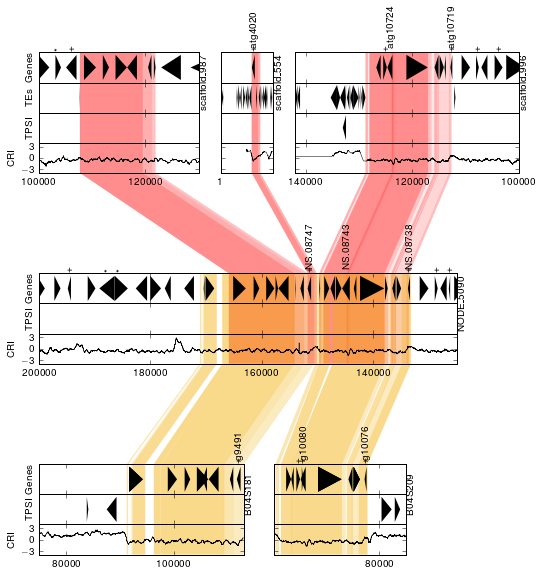

In [26]:
with open(pjoin(STEPS['scaffold_alignment'], 'promer_files.json'), 'r') as handle:
    promer_files = json.load(handle)

data = [
    {
        'name': 'MNH120',
        'scaffolds': ['scaffold_987','scaffold_554','scaffold_996'],
        'scaf_names': None,
        'seqs': None,
        'xlims': [(100000, 130000), (0, 9883), (141984, 100000)],
        'ylims': [(-0.6, 0.6), (-0.6, 0.6), (-0.6, 0.6), (-4, 4)],
        'yratios': None,
    },
    {
        'name': 'USR5',
        'scaffolds': ['NODE_5090_length_307152_cov_15.165000'],
        'scaf_names': ['NODE_5090'],
        'seqs': None,
        'xlims': [(200000, 125000)],
        'ylims': [(-0.6, 0.6), (-0.6, 0.6), (-4, 4)],
        'yratios': None,
    },
    {
        'name': 'B04',
        'scaffolds': ['B04S181', 'B04S209'],
        'scaf_names': None,
        'seqs': None,
        'xlims': [(75000, 112942), (99402, 75000)],
        'ylims': [(-0.6, 0.6), (-0.6, 0.6), (-4, 4)],
        'yratios': None,
    },
    ]

fig = plt.figure(figsize=(9, 9))
data = draw_synteny(
    data,
    fig,
    tick_frequency=20000,
    thres=85,
    height_ratios=[4, 3, 3],
    )

fig.savefig(pjoin(STEPS['plotting_alignments'], 'atg4020_synteny.png'), dpi=600)
fig.savefig(pjoin(STEPS['plotting_alignments'], 'atg4020_synteny.svg'))

### atg7465

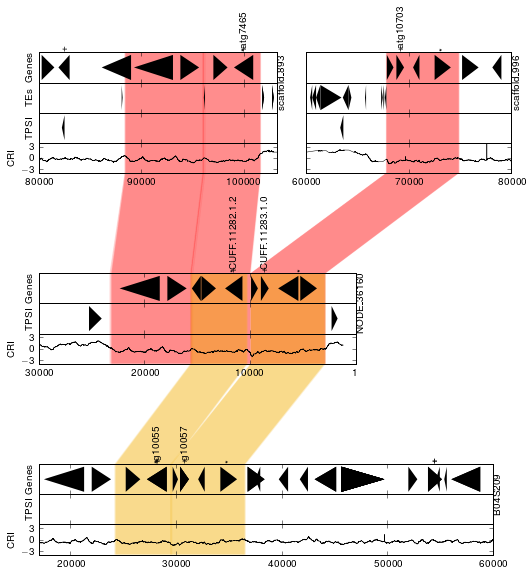

In [27]:
with open(pjoin(STEPS['scaffold_alignment'], 'promer_files.json'), 'r') as handle:
    promer_files = json.load(handle)

data = [
    {
        'name': 'MNH120',
        'scaffolds': ['scaffold_893', 'scaffold_996'],
        'scaf_names': None,
        'seqs': None,
        'xlims': [(80000, 103197), (60000, 80000)],
        'ylims': [(-0.6, 0.6), (-0.6, 0.6), (-0.6, 0.6), (-4, 4)],
        'yratios': None,
    },
    {
        'name': 'USR5',
        'scaffolds': ['NODE_36160_length_249094_cov_15.165792'],
        'scaf_names': ['NODE_36160'],
        'seqs': None,
        'xlims': [(30000, 0)],
        'ylims': [(-0.6, 0.6), (-0.6, 0.6), (-4, 4)],
        'yratios': None,
    },
    {
        'name': 'B04',
        'scaffolds': ['B04S209'],
        'scaf_names': None,
        'seqs': None,
        'xlims': [(17000, 60000)],
        'ylims': [(-0.6, 0.6), (-0.6, 0.6), (-4, 4)],
        'yratios': None,
    },
    ]

fig = plt.figure(figsize=(9, 9))
data = draw_synteny(
    data,
    fig,
    tick_frequency=10000,
    thres=85,
    height_ratios=[4, 3, 3],
    )

fig.savefig(pjoin(STEPS['plotting_alignments'], 'atg7465_synteny.png'), dpi=600)
fig.savefig(pjoin(STEPS['plotting_alignments'], 'atg7465_synteny.svg'))

### atg10703

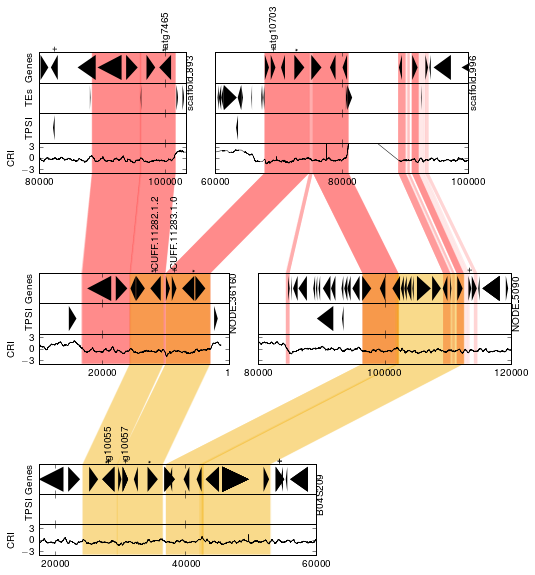

In [28]:
with open(pjoin(STEPS['scaffold_alignment'], 'promer_files.json'), 'r') as handle:
    promer_files = json.load(handle)

data = [
    {
        'name': 'MNH120',
        'scaffolds': ['scaffold_893', 'scaffold_996'],
        'scaf_names': None,
        'seqs': None,
        'xlims': [(80000, 103197), (60000, 100000)],
        'ylims': [(-0.6, 0.6), (-0.6, 0.6), (-0.6, 0.6), (-4, 4)],
        'yratios': None,
    },
    {
        'name': 'USR5',
        'scaffolds': ['NODE_36160_length_249094_cov_15.165792', 'NODE_5090_length_307152_cov_15.165000'],
        'scaf_names': ['NODE_36160', 'NODE_5090'],
        'seqs': None,
        'xlims': [(30000, 0), (80000, 120000)],
        'ylims': [(-0.6, 0.6), (-0.6, 0.6), (-4, 4)],
        'yratios': None,
    },
    {
        'name': 'B04',
        'scaffolds': ['B04S209'],
        'scaf_names': None,
        'seqs': None,
        'xlims': [(17500, 60000)],
        'ylims': [(-0.6, 0.6), (-0.6, 0.6), (-4, 4)],
        'yratios': None,
    },
    ]

fig = plt.figure(figsize=(9, 9))
data = draw_synteny(
    data,
    fig,
    tick_frequency=20000,
    thres=85,
    height_ratios=[4, 3, 3],
    )

fig.savefig(pjoin(STEPS['plotting_alignments'], 'atg10703_synteny.png'), dpi=600)
fig.savefig(pjoin(STEPS['plotting_alignments'], 'atg10703_synteny.svg'))

### atg10719 and atg10724

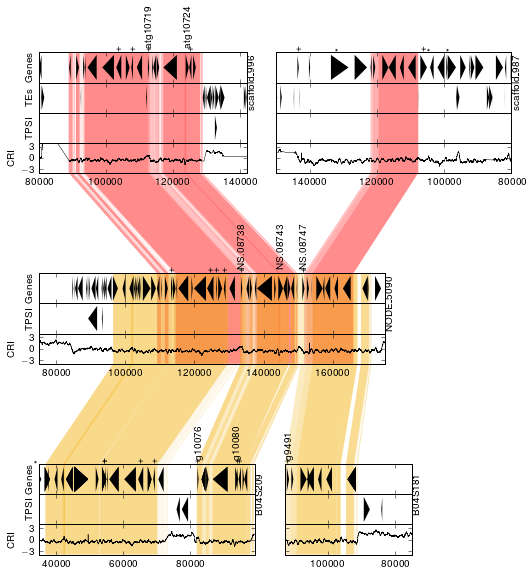

In [29]:
with open(pjoin(STEPS['scaffold_alignment'], 'promer_files.json'), 'r') as handle:
    promer_files = json.load(handle)

data = [
    {
        'name': 'MNH120',
        'scaffolds': ['scaffold_996', 'scaffold_987'],
        'scaf_names': None,
        'seqs': None,
        'xlims': [(80000, 141894), (150000, 80000)],
        'ylims': [(-0.6, 0.6), (-0.6, 0.6), (-0.6, 0.6), (-4, 4)],
        'yratios': None,
    },
    {
        'name': 'USR5',
        'scaffolds': ['NODE_5090_length_307152_cov_15.165000'],
        'scaf_names': ['NODE_5090'],
        'seqs': None,
        'xlims': [(75000, 175000)],
        'ylims': [(-0.6, 0.6), (-0.6, 0.6), (-4, 4)],
        'yratios': None,
    },
    {
        'name': 'B04',
        'scaffolds': ['B04S209', 'B04S181'],
        'scaf_names': None,
        'seqs': None,
        'xlims': [(35000, 99402), (112942, 75000)],
        'ylims': [(-0.6, 0.6), (-0.6, 0.6), (-4, 4)],
        'yratios': None,
    },
    ]

fig = plt.figure(figsize=(9, 9))
data = draw_synteny(
    data,
    fig,
    tick_frequency=20000,
    thres=85,
    height_ratios=[4, 3, 3],
    )

fig.savefig(pjoin(STEPS['plotting_alignments'], 'atg107xx_synteny.png'), dpi=600)
fig.savefig(pjoin(STEPS['plotting_alignments'], 'atg107xx_synteny.svg'))

### atg12487

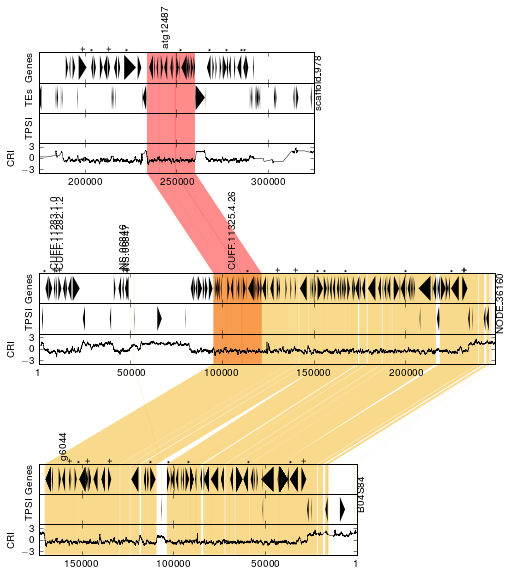

In [30]:
with open(pjoin(STEPS['scaffold_alignment'], 'promer_files.json'), 'r') as handle:
    promer_files = json.load(handle)

data = [
    {
        'name': 'MNH120',
        'scaffolds': ['scaffold_978'],
        'scaf_names': None,
        'seqs': None,
        'xlims': [(175000, 325000)],
        'ylims': [(-0.6, 0.6), (-0.6, 0.6), (-0.6, 0.6), (-4, 4)],
        'yratios': None,
    },
    {
        'name': 'USR5',
        'scaffolds': ['NODE_36160_length_249094_cov_15.165792'],
        'scaf_names': ['NODE_36160'],
        'seqs': None,
        'xlims': None,
        'ylims': [(-0.6, 0.6), (-0.6, 0.6), (-4, 4)],
        'yratios': None,
    },
    {
        'name': 'B04',
        'scaffolds': ['B04S84'],
        'scaf_names': None,
        'seqs': None,
        'xlims': [(173445, 0)],
        'ylims': [(-0.6, 0.6), (-0.6, 0.6), (-4, 4)],
        'yratios': None,
    },
    ]

fig = plt.figure(figsize=(9, 9))
data = draw_synteny(
    data,
    fig,
    tick_frequency=50000,
    thres=85,
    height_ratios=[4, 3, 3],
    )

fig.savefig(pjoin(STEPS['plotting_alignments'], 'atg12487_synteny.png'), dpi=600)
fig.savefig(pjoin(STEPS['plotting_alignments'], 'atg12487_synteny.svg'))

### Step - `broader_alignments`

In [31]:
with open(pjoin(STEPS['region'], 'candidate_homologues.json'), 'r') as handle:
    candidate_homologues = json.load(handle)

buscos = dict()
buscos['MNH120'] = pd.read_csv(pjoin(STEPS['data'], 'full_table_MNH_Fungi'), sep='\t')
buscos['B04'] = pd.read_csv(pjoin(STEPS['data'], 'full_table_B04_Fungi'), sep='\t')
buscos['USR5'] = pd.read_csv(pjoin(STEPS['data'], 'full_table_IV5.Fungi'), sep='\t')

secretome = dict()
location_cols = ['seqid', 'location', 'membrane']
table = pd.read_csv('data/MNH120.location.tsv', sep='\t', names=location_cols)
secretome['MNH120'] = set(table.seqid[(table.location == 'secreted') & (table.membrane == False)])
table = pd.read_csv('data/I5V.location.tsv', sep='\t', names=location_cols)
secretome['USR5'] = set(table.seqid[(table.location == 'secreted') & (table.membrane == False)])
table = pd.read_csv('data/B04.location.tsv', sep='\t', names=location_cols)
secretome['B04'] = set(table.seqid[(table.location == 'secreted') & (table.membrane == False)])

names_to_print = defaultdict(list)
for candidate in CANDIDATES:
    for isolate in GENOMES_TO_SEARCH:
        for hlog in candidate_homologues[candidate][isolate]:
            seq = GENOMES[isolate][hlog['scaffold']]
            features = subset_features(seq, hlog['start'], hlog['end'])
            features = [f for f in features if f.type == 'gene']
            features = [f for f in features if f.strand == hlog['strand']]
            if len(features) == 0:
                start = hlog['start']
                end = hlog['end']
                s = candidate + ' match'
            else:
                feature = features[0]
                start = feature.location.start
                end = feature.location.end
                id_ = feature.id
                s = id_.lstrip('exon.')
                if isolate == 'B04':
                    s = id_.split('.', 1)[1]

            names_to_print[hlog['scaffold']].append({
                's': tex_escape(s),
                'x': (start + end) / 2,
                'y': 1.4,
                'fontsize':9,
                'rotation': 'vertical',
                'verticalalignment': 'bottom',
                'horizontalalignment': 'center',
                })
            
for isolate, table in buscos.items():
    for i, row in table.iterrows():
        start = row['Start']
        end = row['End']
        s = r'$\ast$'
        scaffold = row['Scaffold']
        names_to_print[scaffold].append({
            's': s,
            'x': (start + end) / 2,
            'y': 1.2,
            'fontsize':10,
            'rotation': 'vertical',
            'verticalalignment': 'bottom',
            'horizontalalignment': 'center',
            })

for isolate, seqids in secretome.items():
    for scaffold, seq in GENOMES[isolate].items():
        for feature in seq.features:
            if feature.id in seqids:
                start = feature.location.start
                end = feature.location.end
                s = r'$+$'
                names_to_print[scaffold].append({
                    's': s,
                    'x': (start + end) / 2,
                    'y': 1.025,
                    'fontsize':10,
                    'rotation': 'vertical',
                    'verticalalignment': 'bottom',
                    'horizontalalignment': 'center',
                    })

In [32]:
def draw_broad_synteny(
        data,
        fig,
        tick_frequency=50000,
        thres=85,
        hspace=1,
        height_ratios=None,
        within_links=[],
        cpoint=20
        ):
    max_length = 0
    for grp in data:
        if grp['seqs'] is None:
            grp['seqs'] = [GENOMES[grp['name']][s] for s in grp['scaffolds']]
        if grp['scaf_names'] is None:
            grp['scaf_names'] = grp['scaffolds']
        if grp['xlims'] is None:
            grp['xlims'] = [(0, l) for l in[len(s) for s in grp['seqs']]]
        if grp['yratios'] is None:
            grp['yratios'] = [1 for y in grp['ylims']]
        length = sum([abs(l[1] - l[0]) for l in grp['xlims']])
        if length > max_length:
            max_length = length

    gs = gridspec.GridSpec(len(data), 1, hspace=hspace, height_ratios=height_ratios)

    # Create axes and draw genes
    exon = new_shape(Triangle, width=1, y_offset=-0.5, facecolor='black', linewidth=0)
    gene = new_shape(Feature, shape=exon)
    nblock = new_shape(Rectangle, width=1, y_offset=-0.5, facecolor='red', linewidth=0)
    nblock = new_shape(Feature, shape=nblock)

    for i, grp in enumerate(data):
        grp['axes'] = compound_axis(
            grp['xlims'],
            grp['ylims'],
            gs[i],
            fig,
            xscaling=max_length,
            hspace=0,
            )
        for ax, name in zip(grp['axes'][0], grp['scaf_names']):
            if ax is not None:
                ax.tick_params(labeltop='off', labelbottom='off')
                ax.xaxis.set_major_locator(MultipleLocator(base=tick_frequency))
                ax.xaxis.set_major_formatter(SeqFormatter())
                ax.text(1.0, 0, 
                        tex_escape(name),
                        transform=ax.transAxes,
                        verticalalignment='center',
                        rotation='vertical',
                        horizontalalignment='left',
                        )

        for ax, seq in zip(grp['axes'][0], grp['seqs']):
            track = FeatureTrack()
            #nblocks = [f for f in seq.features if 'nn2gff' in f.qualifiers['source']]
            #track.add_bpfeatures(feats, obj=nblock)
            feats = [f for f in seq.features if f.type == 'gene']
            track.add_bpfeatures(feats, obj=gene)
            feature_patches = track.draw(ax)
            trans = blended_transform_factory(ax.transData, ax.transAxes)
            if seq.id in names_to_print:
                for name in names_to_print[seq.id]:
                    xlims = ax.get_xlim()
                    if min(xlims) <= name['x'] <= max(xlims):
                        ax.text(transform=trans, **name)

        grp['axes'][0, 0].set_yticks([])
        grp['axes'][0, 0].set_ylabel('Genes')

    # Draw other features/tracks here
    for i, grp in enumerate(data):
        cri = bedtrack_parser(GENOME_FILES[grp['name']]['CRI'], grp['scaffolds'])
        for ax, scaf in zip(grp['axes'][-1], grp['scaffolds']):
            x = cri[scaf]['x']
            y = cri[scaf]['y']
            x, y = zip(*sorted(zip(x, y), key=lambda t: t[0]))
            ax.plot(x, y, color='black', lw=0.5)
        grp['axes'][-1, 0].set_ylabel('CRI')
        grp['axes'][-1, 0].set_yticks([-3, 0, 3])

    # Draw links
    all_links = list()
    colours = cat_colours[2], cat_colours[0]
    for i in within_links:
        for scafleft, axleft in zip(data[i]['scaffolds'], data[i]['axes'][-1]):
            lims = [0, sum(data[0]['yratios'])/data[i]['yratios'][-1]]
            for scafright, axright in zip(data[i]['scaffolds'], data[i]['axes'][-1]):
                link = new_shape(
                    CrossLink,
                    ax1=axleft,
                    ax2=axright,
                    ax1_yrange=lims,
                    ax1_cpoint=cpoint,
                    ax2_cpoint=cpoint,
                    facecolor=colours[(i + 1) % 2],
                    linewidth=0.,
                    )
                links = LinkCollection(link, add_to_fig=True)
                x = links.add_coords(
                    fp=promer_files[scafleft][scafright]['coords'],
                    r=scafleft,
                    q=scafright,
                    thres=thres,
                    )
                all_links.append(links)
    
    for i in range(1, len(data)):
        dtop = data[i - 1]
        dbot = data[i]
        for scaftop, axtop in zip(dtop['scaffolds'], dtop['axes'][-1]):
            for scafbot, axbot in zip(dbot['scaffolds'], dbot['axes'][-1]):
                if axtop is None or axbot is None:
                    continue
                toplims = [sum(dtop['yratios'])/dtop['yratios'][-1], 0]
                botlims = [0, sum(dbot['yratios'])/dbot['yratios'][0]]
                link = new_shape(
                    CrossLink,
                    ax1=axtop,
                    ax2=axbot,
                    ax1_yrange=toplims,
                    ax2_yrange=botlims,
                    facecolor=colours[i % 2],
                    linewidth=0.,
                    )
                links = LinkCollection(link, add_to_fig=True)
                x = links.add_coords(
                    fp=promer_files[scaftop][scafbot]['coords'],
                    r=scaftop,
                    q=scafbot,
                    thres=thres,
                    )
                all_links.append(links)
    for link in all_links:
        link.draw()
    return data, all_links

In [33]:
with open(pjoin(STEPS['region'], 'candidate_scaffolds.json'), 'r') as handle:
    candidate_scaffolds = json.load(handle)
with open(pjoin(STEPS['region'], 'candidate_homologues.json'), 'r') as handle:
    candidate_homologues = json.load(handle)

#candidate_homologues['atg12487']['B04']
#candidate_scaffolds['NODE_22469_length_290494_cov_15.434708']['B04']
len(GENOMES['B04']['B04S283'])

69017

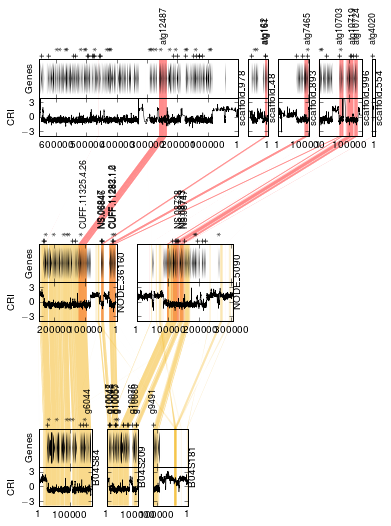

In [34]:
with open(pjoin(STEPS['scaffold_alignment'], 'promer_files.json'), 'r') as handle:
    promer_files = json.load(handle)

data = [
    {
        'name': 'MNH120',
        'scaffolds': [
            #'scaffold_901',
            'scaffold_978',
            'scaffold_48',
            'scaffold_893',
            'scaffold_996',
            'scaffold_554',
            #'scaffold_677',
            ],
        'scaf_names': None,
        'seqs': None,
        'xlims': [
            #(661547, 0),
            (656374, 0),
            (65488, 0),
            (0, 103197),
            (0, 141894),
            (9883, 0),
            #(0, 170486),
            ],
        'ylims': [(-0.6, 0.6), (-4, 4)],
        'yratios': None,
    },
    {
        'name': 'USR5',
        'scaffolds': [
            'NODE_36160_length_249094_cov_15.165792',
            'NODE_5090_length_307152_cov_15.165000',
            ],
        'scaf_names': [
            'NODE_36160',
            'NODE_5090',
            ],
        'seqs': None,
        'xlims': [(249012, 0), (0, 306619)],
        'ylims': [(-0.6, 0.6), (-4, 4)],
        'yratios': None,
    },
    {
        'name': 'B04',
        'scaffolds': [
            'B04S84', 
            'B04S209',
            'B04S181',
            #'B04S283',
            ],
        'scaf_names': None,
        'seqs': None,
        'xlims': [
            (0, 173445),
            (0, 99402),
            (112942, 0),
            #(0, 69017),
            ],
        'ylims': [(-0.6, 0.6), (-4, 4)],
        'yratios': None,
    },
    ]

fig = plt.figure(figsize=(6.2, 8))
data, links = draw_broad_synteny(
    data,
    fig,
    hspace=1.4,
    tick_frequency=100000,
    thres=85,
    )

fig.savefig(pjoin(STEPS['broader_alignments'], 'group_synteny.png'), dpi=600)
fig.savefig(pjoin(STEPS['broader_alignments'], 'group_synteny.svg'))

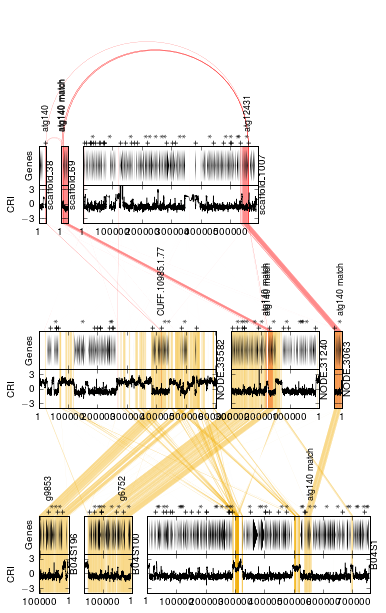

In [35]:
with open(pjoin(STEPS['scaffold_alignment'], 'promer_files.json'), 'r') as handle:
    promer_files = json.load(handle)

data = [
    {
        'name': 'MNH120',
        'scaffolds': ['scaffold_38', 'scaffold_69', 'scaffold_1007'],
        'scaf_names': None,
        'seqs': None,
        'xlims': [(0, 25314), (0, 23482), (0, 595422)],
        'ylims': [(-0.6, 0.6), (-4, 4)],
        'yratios': None,
    },
    {
        'name': 'USR5',
        'scaffolds': [
            'NODE_35582_length_606476_cov_15.460932',
            'NODE_31240_length_299966_cov_15.629742',
            'NODE_3063_length_27277_cov_15.580489',
            ], 
        'scaf_names': ['NODE_35582', 'NODE_31240', 'NODE_3063'],
        'seqs': None,
        'xlims': [(0, 605022), (299486, 0), (27322, 0)],
        'ylims': [(-0.6, 0.6), (-4, 4)],
        'yratios': None,
    },
    {
        'name': 'B04',
        'scaffolds': ['B04S196', 'B04S100', 'B04S1'],
        'scaf_names': None,
        'seqs': None,
        'xlims': [(104567, 0), (161523, 0), (0, 758575)],
        'ylims': [(-0.6, 0.6), (-4, 4)],
        'yratios': None,
    },
    ]

tick_frequency = 100000
fig = plt.figure(figsize=(6.2, 8))
data = draw_broad_synteny(
    data,
    fig,
    tick_frequency=100000,
    thres=70,
    hspace=1.4,
    within_links=[0],
    cpoint=8,
    )
fig.savefig(pjoin(STEPS['broader_alignments'], 'atg140_all_homologues.png'), dpi=600)
fig.savefig(pjoin(STEPS['broader_alignments'], 'atg140_all_homologues.svg'))

### Step - ripcrawl_demo

In [37]:
with open(pjoin(STEPS['region'], 'candidate_homologues.json'), 'r') as handle:
    candidate_homologues = json.load(handle)

names_to_print = defaultdict(list)

for isolate, scaffolds in GENOMES.items():
    for scaffold, seq in scaffolds.items():
        for feature in seq.features:
            if feature.type != 'gene':
                continue

            start = feature.location.start
            end = feature.location.end
            id_ = feature.id
            s = id_.lstrip('exon.')
            if isolate == 'B04':
                s = id_.split('.', 1)[1]

            names_to_print[scaffold].append({
                's': tex_escape(s),
                'x': (start + end) / 2,
                'y': 1.05,
                'fontsize':9,
                'rotation': 'vertical',
                'verticalalignment': 'bottom',
                'horizontalalignment': 'center',
                })

In [50]:
def draw_region(
        data,
        fig,
        tick_frequency=50000,
        height_ratios=None,
        hspace=0,
        ):
    max_length = 0
    for grp in data:
        if grp['seqs'] is None:
            grp['seqs'] = [GENOMES[grp['name']][s] for s in grp['scaffolds']]
        if grp['scaf_names'] is None:
            grp['scaf_names'] = grp['scaffolds']
        if grp['xlims'] is None:
            grp['xlims'] = [(0, l) for l in[len(s) for s in grp['seqs']]]
        if grp['yratios'] is None:
            grp['yratios'] = [1 for y in grp['ylims']]
        length = sum([abs(l[1] - l[0]) for l in grp['xlims']])
        if length > max_length:
            max_length = length

    gs = gridspec.GridSpec(len(data), 1, hspace=hspace, height_ratios=height_ratios)

    # Create axes and draw genes
    exon = new_shape(Triangle, width=1, y_offset=-0.5, facecolor='black', linewidth=0)
    gene = new_shape(Feature, shape=exon)
    nblock = new_shape(Rectangle, width=1, y_offset=-0.5, facecolor='red', linewidth=0)
    nblock = new_shape(Feature, shape=nblock)

    for i, grp in enumerate(data):
        grp['axes'] = compound_axis(
            grp['xlims'],
            grp['ylims'],
            gs[i],
            fig,
            xscaling=max_length,
            hspace=0,
            )
        for ax, name in zip(grp['axes'][0], grp['scaf_names']):
            if ax is not None:
                ax.tick_params(labeltop='off', labelbottom='off')
                ax.xaxis.set_major_locator(MultipleLocator(base=tick_frequency))
                ax.xaxis.set_major_formatter(SeqFormatter())
                """ax.text(1.0, 0, 
                    tex_escape(name),
                    transform=ax.transAxes,
                    verticalalignment='center',
                    rotation='vertical',
                    horizontalalignment='left',
                    )"""
                #ax.text(0, 1.05, tex_escape(name), transform=ax.transAxes, verticalalignment='bottom')

        for ax, seq in zip(grp['axes'][0], grp['seqs']):
            track = FeatureTrack()
            #nblocks = [f for f in seq.features if 'nn2gff' in f.qualifiers['source']]
            #track.add_bpfeatures(feats, obj=nblock)
            feats = [f for f in seq.features if f.type == 'gene']
            track.add_bpfeatures(feats, obj=gene)
            feature_patches = track.draw(ax)
            trans = blended_transform_factory(ax.transData, ax.transAxes)
            if seq.id in names_to_print:
                for name in names_to_print[seq.id]:
                    xlims = ax.get_xlim()
                    if min(xlims) <= name['x'] <= max(xlims):
                        ax.text(transform=trans, **name)

        grp['axes'][0, 0].set_yticks([])
        grp['axes'][0, 0].set_ylabel('Genes')

    # Draw other features/tracks here
    for i, grp in enumerate(data):
        if grp['name'] == 'MNH120':
            grp['axes'][1, 0].set_yticks([])
            grp['axes'][1, 0].set_ylabel('TEs')
            for ax, seq in zip(grp['axes'][1], grp['seqs']):
                track = FeatureTrack()
                feats = [f for f in seq.features if 'mnh120_REPET_TEs' in f.qualifiers['source']]
                track.add_bpfeatures(feats, obj=gene)
                feature_patches = track.draw(ax)

        grp['axes'][-2, 0].set_yticks([])
        grp['axes'][-2, 0].set_ylabel('TPSI')
        for ax, seq in zip(grp['axes'][-2], grp['seqs']):
            track = FeatureTrack()
            feats = [f for f in seq.features if 'TransposonPSI' in f.qualifiers['source']]
            track.add_bpfeatures(feats, obj=gene)
            feature_patches = track.draw(ax)
        cri = bedtrack_parser(GENOME_FILES[grp['name']]['CRI'], grp['scaffolds'])
        for ax, scaf in zip(grp['axes'][-1], grp['scaffolds']):
            x = cri[scaf]['x']
            y = cri[scaf]['y']
            x, y = zip(*sorted(zip(x, y), key=lambda t: t[0]))
            ax.plot(x, y, color='black', lw=0.5)
        grp['axes'][-1, 0].set_ylabel('CRI')
        grp['axes'][-1, 0].set_yticks([-3, 0, 3])
    data[-1]['axes'][-1, 0].set_xlabel('Scaffold position (bp)')

    return data

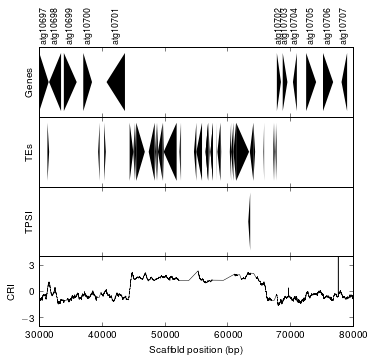

In [53]:
with open(pjoin(STEPS['scaffold_alignment'], 'promer_files.json'), 'r') as handle:
    promer_files = json.load(handle)

data = [
    {
        'name': 'MNH120',
        'scaffolds': ['scaffold_996'],
        'scaf_names': None,
        'seqs': None,
        'xlims': [(30000, 80000)],
        'ylims': [(-0.6, 0.6), (-0.6, 0.6), (-0.6, 0.6), (-4, 4)],
        'yratios': None,
    },
    ]

fig = plt.figure(figsize=(6.2, 5))
data = draw_region(
    data,
    fig,
    tick_frequency=10000,
    )
fig.savefig(pjoin(STEPS['ripcrawl_demo'], 'MNH120_ripcrawl.png'), dpi=600)
fig.savefig(pjoin(STEPS['ripcrawl_demo'], 'MNH120_ripcrawl.svg'))

### Step - gypsy

In [54]:
with open(pjoin(STEPS['region'], 'candidate_homologues.json'), 'r') as handle:
    candidate_homologues = json.load(handle)

names_to_print = defaultdict(list)

for isolate, scaffolds in GENOMES.items():
    for scaffold, seq in scaffolds.items():
        for feature in seq.features:
            if feature.type != 'gene':
                continue

            start = feature.location.start
            end = feature.location.end
            id_ = feature.id
            s = id_.lstrip('exon.')
            if isolate == 'B04':
                s = id_.split('.', 1)[1]

            names_to_print[scaffold].append({
                's': tex_escape(s),
                'x': (start + end) / 2,
                'y': 1.05,
                'fontsize':9,
                'rotation': 'vertical',
                'verticalalignment': 'bottom',
                'horizontalalignment': 'center',
                })

In [61]:
def draw_region(
        data,
        fig,
        tick_frequency=50000,
        height_ratios=None,
        hspace=0,
        ):
    max_length = 0
    for grp in data:
        if grp['seqs'] is None:
            grp['seqs'] = [GENOMES[grp['name']][s] for s in grp['scaffolds']]
        if grp['scaf_names'] is None:
            grp['scaf_names'] = grp['scaffolds']
        if grp['xlims'] is None:
            grp['xlims'] = [(0, l) for l in[len(s) for s in grp['seqs']]]
        if grp['yratios'] is None:
            grp['yratios'] = [1 for y in grp['ylims']]
        length = sum([abs(l[1] - l[0]) for l in grp['xlims']])
        if length > max_length:
            max_length = length

    gs = gridspec.GridSpec(len(data), 1, hspace=hspace, height_ratios=height_ratios)

    # Create axes and draw genes
    exon = new_shape(Triangle, width=1, y_offset=-0.5, facecolor='black', linewidth=0)
    gene = new_shape(Feature, shape=exon)
    nblock = new_shape(Rectangle, width=1, y_offset=-0.5, facecolor='black', linewidth=0)
    nblock = new_shape(Feature, shape=nblock)

    for i, grp in enumerate(data):
        grp['axes'] = compound_axis(
            grp['xlims'],
            grp['ylims'],
            gs[i],
            fig,
            xscaling=max_length,
            hspace=0,
            )
        for ax, name in zip(grp['axes'][0], grp['scaf_names']):
            if ax is not None:
                ax.tick_params(labeltop='off', labelbottom='off')
                ax.xaxis.set_major_locator(MultipleLocator(base=tick_frequency))
                ax.xaxis.set_major_formatter(SeqFormatter())
                """ax.text(1.0, 0, 
                    tex_escape(name),
                    transform=ax.transAxes,
                    verticalalignment='center',
                    rotation='vertical',
                    horizontalalignment='left',
                    )"""
                #ax.text(0, 1.05, tex_escape(name), transform=ax.transAxes, verticalalignment='bottom')

        for ax, seq in zip(grp['axes'][0], grp['seqs']):
            track = FeatureTrack()
            #nblocks = [f for f in seq.features if 'nn2gff' in f.qualifiers['source']]
            #track.add_bpfeatures(feats, obj=nblock)
            feats = [f for f in seq.features if f.type == 'gene']
            track.add_bpfeatures(feats, obj=gene)
            feature_patches = track.draw(ax)
            trans = blended_transform_factory(ax.transData, ax.transAxes)
            if seq.id in names_to_print:
                for name in names_to_print[seq.id]:
                    xlims = ax.get_xlim()
                    if min(xlims) <= name['x'] <= max(xlims):
                        ax.text(transform=trans, **name)

        grp['axes'][0, 0].set_yticks([])
        grp['axes'][0, 0].set_ylabel('Genes')

    # Draw other features/tracks here
    for i, grp in enumerate(data):
        if grp['name'] == 'MNH120':
            grp['axes'][1, 0].set_yticks([])
            grp['axes'][1, 0].set_ylabel('TEs')
            for ax, seq in zip(grp['axes'][1], grp['seqs']):
                track = FeatureTrack()
                feats = [f for f in seq.features if 'mnh120_REPET_TEs' in f.qualifiers['source']]
                track.add_bpfeatures(feats, obj=gene)
                feature_patches = track.draw(ax)

        grp['axes'][-3, 0].set_yticks([])
        grp['axes'][-3, 0].set_ylabel('TPSI')
        for ax, seq in zip(grp['axes'][-3], grp['seqs']):
            track = FeatureTrack()
            feats = [f for f in seq.features if 'TransposonPSI' in f.qualifiers['source']]
            track.add_bpfeatures(feats, obj=gene)
            feature_patches = track.draw(ax)
        
        grp['axes'][-2, 0].set_yticks([])
        grp['axes'][-2, 0].set_ylabel('TRF')
        for ax, seq in zip(grp['axes'][-2], grp['seqs']):
            track = FeatureTrack()
            feats = [f for f in seq.features if 'TRF' in f.qualifiers['source']]
            track.add_bpfeatures(feats, obj=nblock)
            feature_patches = track.draw(ax)

        cri = bedtrack_parser(GENOME_FILES[grp['name']]['CRI'], grp['scaffolds'])
        grp['axes'][-1, 0].set_ylabel('CRI')
        grp['axes'][-1, 0].set_yticks([-3, 0, 3])
        for ax, scaf in zip(grp['axes'][-1], grp['scaffolds']):
            x = cri[scaf]['x']
            y = cri[scaf]['y']
            x, y = zip(*sorted(zip(x, y), key=lambda t: t[0]))
            ax.plot(x, y, color='black', lw=0.5)
    data[-1]['axes'][-1, 0].set_xlabel('Scaffold position (bp)')

    return data

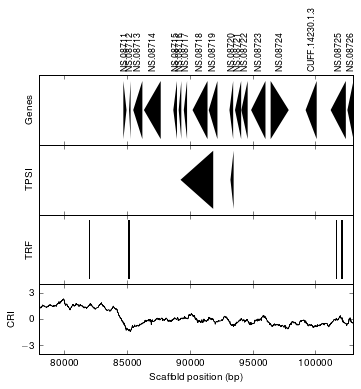

In [69]:
with open(pjoin(STEPS['scaffold_alignment'], 'promer_files.json'), 'r') as handle:
    promer_files = json.load(handle)

data = [
    {
        'name': 'USR5',
        'scaffolds': ['NODE_5090_length_307152_cov_15.165000'],
        'scaf_names': None,
        'seqs': None,
        'xlims': [(78000, 103000)],
        'ylims': [(-0.6, 0.6), (-0.6, 0.6), (-0.6, 0.6), (-4, 4)],
        'yratios': None,
    },
    ]

fig = plt.figure(figsize=(6.2, 5))
data = draw_region(
    data,
    fig,
    tick_frequency=5000,
    )
fig.savefig(pjoin(STEPS['gypsy'], 'USR5_gypsy.png'), dpi=600)
fig.savefig(pjoin(STEPS['gypsy'], 'USR5_gypsy.svg'))